# Сравнение эффективности линейной и LSTM моделей

## Подключение библиотек

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input


## 1. Загрузка данных


In [11]:
file_path = './dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

all_features = [
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3',
    'hour',
    'day_of_week',
    'is_weekend',
    'month',
    'hour_sin',
    'hour_cos'
]

time_features = ['hour', 'day_of_week', 'is_weekend', 'month', 'hour_sin', 'hour_cos']

X_all = df[all_features]          
X_time = df[time_features]       
y_power = df['Global_active_power']

## 2. Обучение и предсказание по линейной модели (только временные признаки)

In [ ]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_time, y_power, test_size=0.2, shuffle=False
)

lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train_lin)
lin_pred = lin_model.predict(X_test_lin)


## 3. Подготовка данных для LSTM (все признаки + целевая переменная)


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[all_features + ['Global_active_power']])
SEQ_LENGTH = 24

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]  
        y = data[i+seq_length, -1]     
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
 
X_seq, y_seq = create_sequences(scaled_data, SEQ_LENGTH)

split_idx = int(len(X_seq) * 0.8)
X_train_lstm, X_test_lstm = X_seq[:split_idx], X_seq[split_idx:]
y_train_lstm, y_test_lstm = y_seq[:split_idx], y_seq[split_idx:]

## 4. Обучение LSTM модели

In [ ]:
lstm_model = Sequential([
    Input(shape=(SEQ_LENGTH, X_seq.shape[2])),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1, verbose=0) 



## 5. Предсказание LSTM на тестовой выборке


In [ ]:
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
last_features = X_test_lstm[:, -1, :] 
lstm_pred_scaled = lstm_pred_scaled.reshape(-1, 1)  
pred_with_target = np.hstack([last_features, lstm_pred_scaled])
real_values = scaler.inverse_transform(pred_with_target)
lstm_pred = real_values[:, -1]

12971/12971 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step



## 6. График: сравнение предсказаний и реальных значений


Linear Regression MSE: 1.1607275566848276
LSTM MSE: 1.4501792332602692


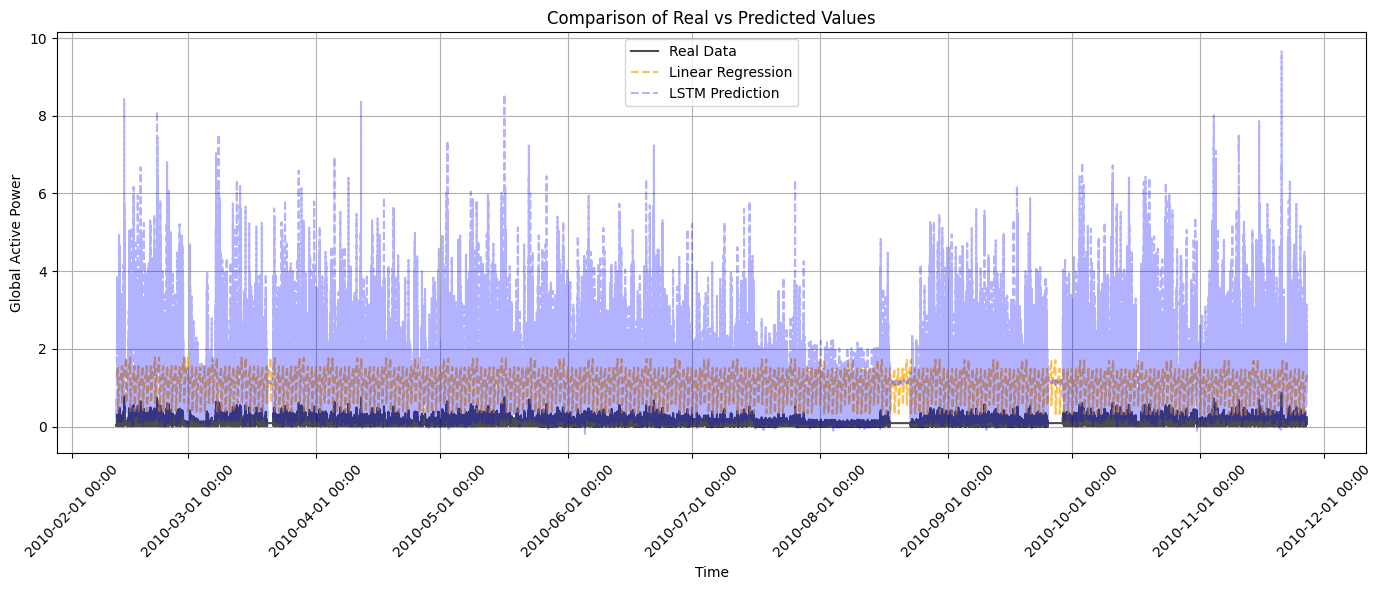

In [ ]:
print("Linear Regression MSE:", mean_squared_error(y_test_lstm, lin_pred[-len(lstm_pred):]))
print("LSTM MSE:", mean_squared_error(y_test_lstm, lstm_pred))

plt.figure(figsize=(14, 6))
test_dates = df.index[-len(lstm_pred):]  

plt.plot(test_dates, y_test_lstm, label="Real Data", color='black', alpha=0.7)
plt.plot(test_dates, lin_pred[-len(lstm_pred):], label="Linear Regression", linestyle='--', color='orange', alpha=0.7)
plt.plot(test_dates, lstm_pred, label="LSTM Prediction", linestyle='--', color='blue', alpha=0.3)

plt.title("Comparison of Real vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.tight_layout()
plt.show()

## 7. Таблица результатов

In [ ]:
test_dates = df.index[-len(lstm_pred):]

results_df = pd.DataFrame({
    'datetime': test_dates,
    'real_value': y_test_lstm,
    'linear_pred': lin_pred[-len(lstm_pred):],
    'lstm_pred': lstm_pred
})

results_df.reset_index(drop=True, inplace=True)
print(results_df.head(20).to_string(index=False)) 

           datetime  real_value  linear_pred  lstm_pred
2010-02-11 15:36:00    0.023176     1.280454   0.266887
2010-02-11 15:37:00    0.028789     1.280454   0.272833
2010-02-11 15:38:00    0.029875     1.280454   0.387527
2010-02-11 15:39:00    0.030418     1.280454   0.351482
2010-02-11 15:40:00    0.030599     1.280454   0.356596
2010-02-11 15:41:00    0.030418     1.280454   0.347867
2010-02-11 15:42:00    0.030599     1.280454   0.357720
2010-02-11 15:43:00    0.030418     1.280454   0.355472
2010-02-11 15:44:00    0.030056     1.280454   0.353739
2010-02-11 15:45:00    0.029513     1.280454   0.352380
2010-02-11 15:46:00    0.029513     1.280454   0.345195
2010-02-11 15:47:00    0.029513     1.280454   0.354615
2010-02-11 15:48:00    0.028608     1.280454   0.351813
2010-02-11 15:49:00    0.031867     1.280454   0.348434
2010-02-11 15:50:00    0.032953     1.280454   0.410641
2010-02-11 15:51:00    0.032591     1.280454   0.389670
2010-02-11 15:52:00    0.032229     1.280454   0